In [1]:

# * Import libaries for this project
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sodapy import Socrata
from matplotlib import pyplot as plt

# * Get NYC OPEN DATA api token from environment

import os
API_TOKEN = os.environ.get("API_TOKEN") #! Save NYC OPEN DATA API token too the variable API_TOKEN

In [2]:

# * Get data from NYC open data

client = Socrata('data.cityofnewyork.us', API_TOKEN)
def fetch_data(data_uuid, nrows = None, usecols = [], chunksize = 5000):
    record_length = int(client.get(data_uuid, select="COUNT(*)")[0]['COUNT'])
    nrows = min(0 if nrows is None else nrows, record_length)
    start = 0
    results =[]
    while start <= nrows:
      results.extend( client.get(data_uuid, offset=start, limit=chunksize))
      start = start + chunksize
    return pd.DataFrame.from_records(results)
df1 = fetch_data('m27t-ht3h') # ! School Math Results
df2 = fetch_data('qkpp-pbi8') # ! School ELA Results


In [3]:

#* Compares possible related columns from math and ela dataframe

print('School Math Results Columns:\n',df1.columns.tolist(),'\n')
print('School ELA Results Columns:\n',df2.columns.tolist())

School Math Results Columns:
 ['dbn', 'school_name', 'grade', 'year', 'category', 'number_tested', 'mean_scale_score', 'level_1', 'level_1_1', 'level_2', 'level_2_1', 'level_3', 'level_3_1', 'level_4', 'level_4_1', 'level_3_4', 'level_3_4_1'] 

School ELA Results Columns:
 ['dbn', 'school_name', 'grade', 'year', 'category', 'number_tested', 'mean_scale_score', 'level_1', 'level_1_1', 'level_2', 'level_2_1', 'level_3', 'level_3_1', 'level_4', 'level_4_1', 'level_3_4', 'level_3_4_1']


In [4]:

# * Creates new dataframe that merges School Math Results dataframe and School ELA Results dataframe together by related columns

merged_df = pd.merge(df1, df2, how='inner', on=['dbn','school_name','grade','year'])

# * Uncomment to see merged dataframe
# merged_df

In [5]:

# * Creates a new dataframe with useful data

recolumned_df = merged_df[['dbn','school_name','grade','year','number_tested_x','mean_scale_score_x','number_tested_y','mean_scale_score_y']]

# * Uncomment to see dataframe cleaned up columns
# recolumned_df

In [6]:

# * Clean update dataframe 

# * removes rows with incomplete or irrelevant data
recolumned_df = recolumned_df[recolumned_df.mean_scale_score_x != 's']
recolumned_df = recolumned_df[recolumned_df.mean_scale_score_y != 's']

recolumned_df = recolumned_df[recolumned_df.grade != 'All Grades']

# * Update columns that have true numerical values to numerical values
recolumned_df['number_tested_x'] = pd.to_numeric(recolumned_df['number_tested_x'])
recolumned_df['number_tested_y'] = pd.to_numeric(recolumned_df['number_tested_y'])
recolumned_df['mean_scale_score_x'] = pd.to_numeric(recolumned_df['mean_scale_score_x'])
recolumned_df['mean_scale_score_y'] = pd.to_numeric(recolumned_df['mean_scale_score_y'])

In [7]:

# * Rename columns to give more context of values in columns

new_df = recolumned_df.rename(columns={"number_tested_x": "number_tested_math", "number_tested_y": "number_tested_ela","mean_scale_score_x": "mean_scale_score_math","mean_scale_score_y": "mean_scale_score_ela"})

# * Uncomment to see dataframe with cleaned up columns and columns' name conventions
# new_df

In [8]:

# * General stats of each columns

new_df.describe()

,number_tested_math,mean_scale_score_math,number_tested_ela,mean_scale_score_ela
count,3795.000000,3795.000000,3795.000000,3795.000000
mean,69.124901,355.126482,69.338076,355.239262
std,47.211971,114.224203,48.254835,114.499063
min,6.000000,242.000000,6.000000,247.000000
25%,41.000000,287.000000,41.000000,289.000000
50%,58.000000,309.000000,58.000000,308.000000
75%,89.000000,342.000000,89.000000,336.000000
max,466.000000,640.000000,452.000000,637.000000


In [9]:

# * Create new columns: school's district , school's borough, school's school number

new_df['district'] = new_df.dbn.str[:2]
new_df['borough'] = new_df.dbn.str[2]
new_df['school_number'] = new_df.dbn.str[3:]

new_df.reset_index(inplace=True, drop=True)

# * Uncomment to see the first five rows of the new dataframe with additional data about school
# new_df.head()

In [10]:

# * Useful data to group dataframe by 

print("Districts:",new_df.district.unique().tolist())
print("Boroughs:",new_df.borough.unique().tolist())
print("School Years:",new_df.year.unique().tolist())
print("Grade Levels:",new_df.grade.unique().tolist())

print("Total Values:",len(new_df.district.tolist()))



Districts: ['01', '02', '03', '04', '05', '06']
Boroughs: ['M']
School Years: ['2013', '2014', '2015', '2016', '2017', '2018']
Grade Levels: ['3', '4', '5', '6', '7', '8']
Total Values: 3795


In [11]:

# * Find out the distrubion of dataframe by group of district number

for i in new_df.district.unique().tolist():
    dfA = new_df[new_df.district == i ]
    i = int(i)
    print(f"Districts {i} Entries:",len(dfA))

# ? Why is district 2 has so many values ?
# * District 2 is the largest district in manhatten

Districts 1 Entries: 477
Districts 2 Entries: 946
Districts 3 Entries: 687
Districts 4 Entries: 587
Districts 5 Entries: 463
Districts 6 Entries: 635


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


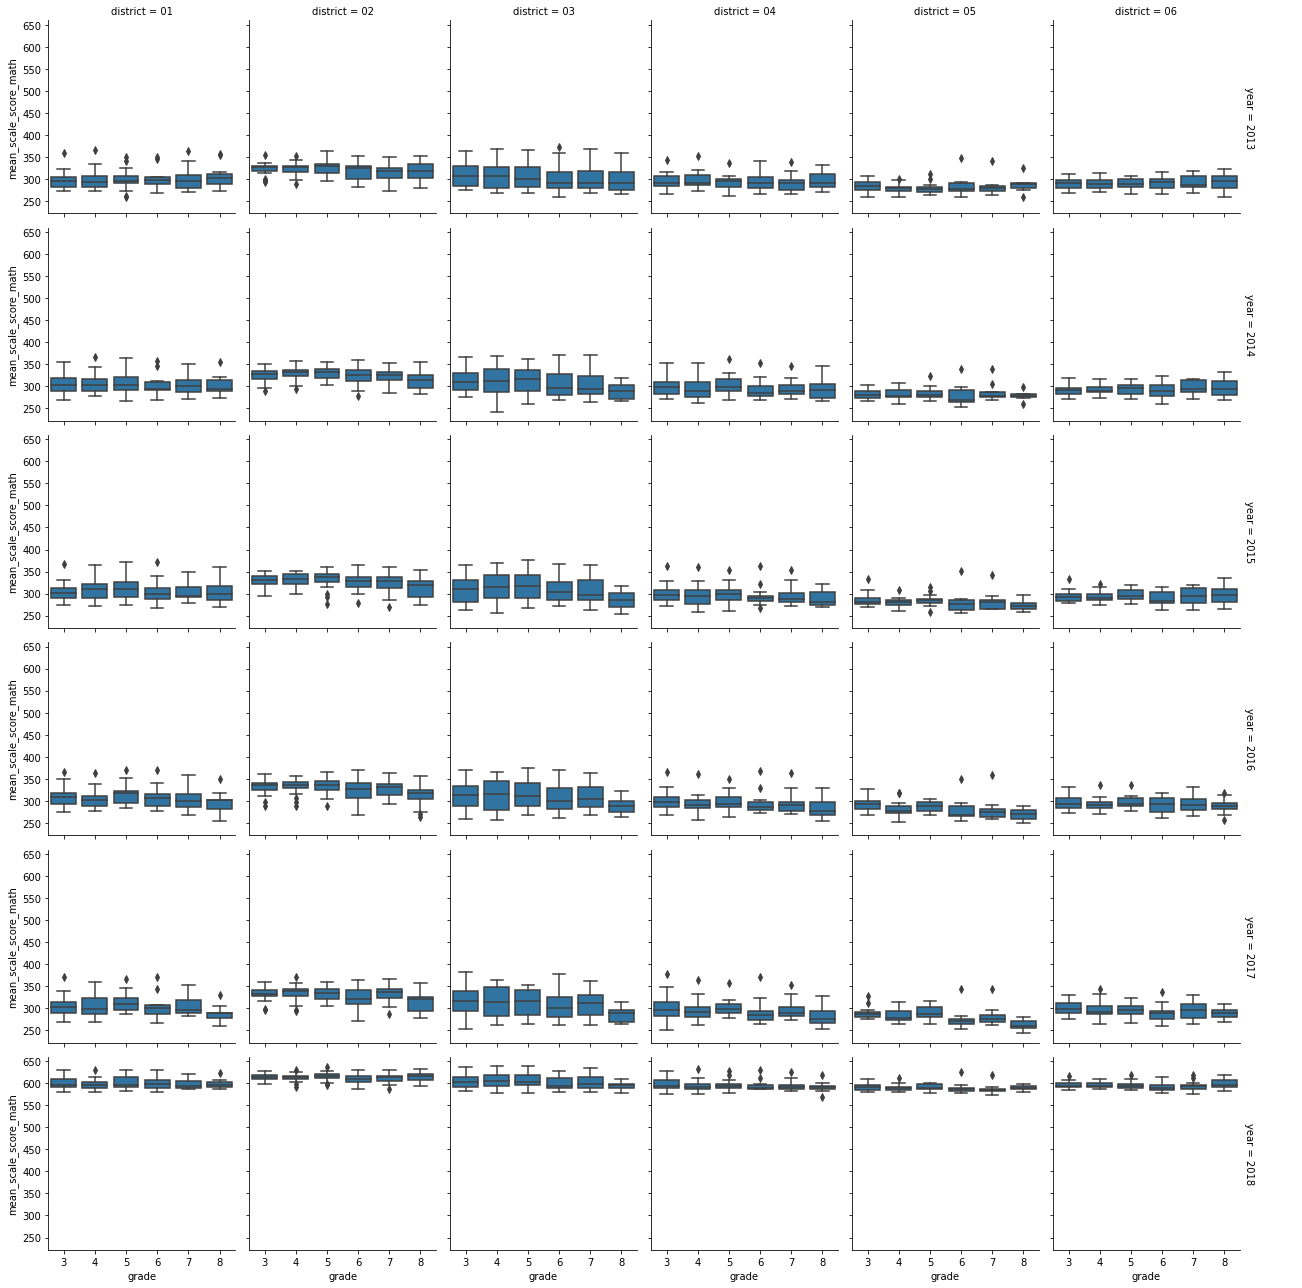

In [12]:
# sns.boxplot(x='district',y='mean_scale_score_ela',data=df_2013)

# * Create a table where columns are district numbers and the rows are the years and each postion is a boxplot of mean math scores within that district and year across the different grade levels
sea = sns.FacetGrid(data=new_df, col = "district",row='year', margin_titles = True)
sea.map(sns.boxplot,"grade", "mean_scale_score_math")
sea.add_legend()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


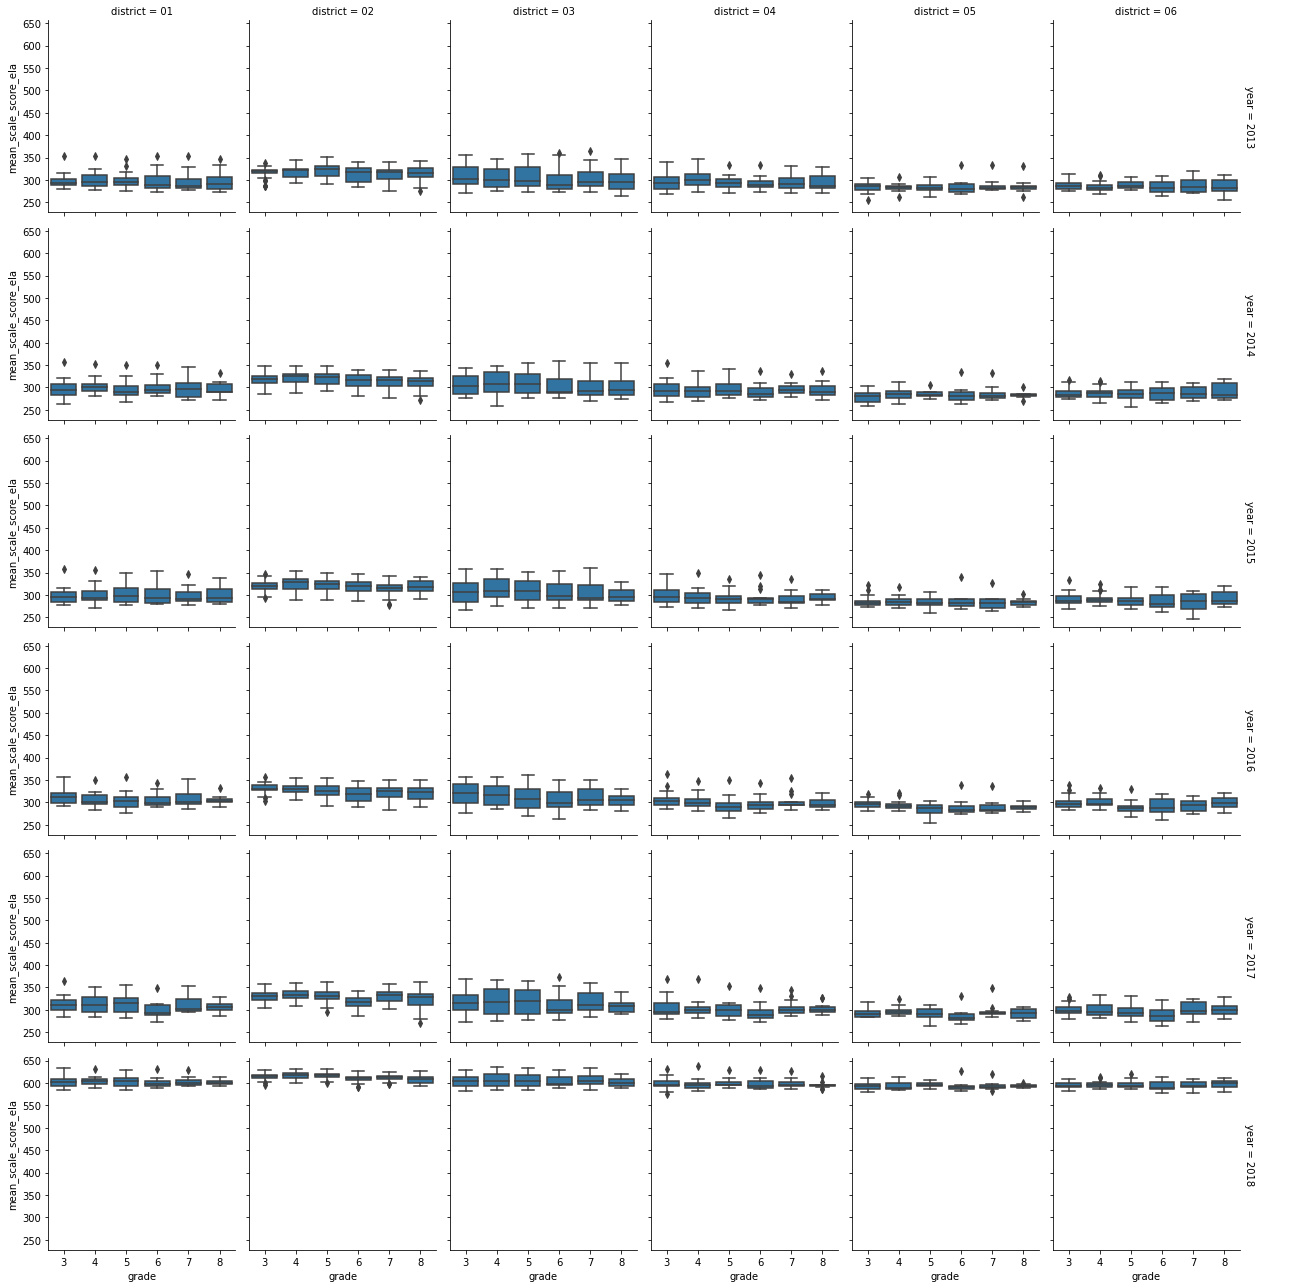

In [13]:

# * Create a table where columns are district numbers and the rows are the years and each postion is a boxplot of mean ela scores within that district and year across the different grade levels
sea = sns.FacetGrid(data=new_df, col = "district",row='year', margin_titles = True)
sea.map(sns.boxplot,"grade", "mean_scale_score_ela")
sea.add_legend()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.10/l

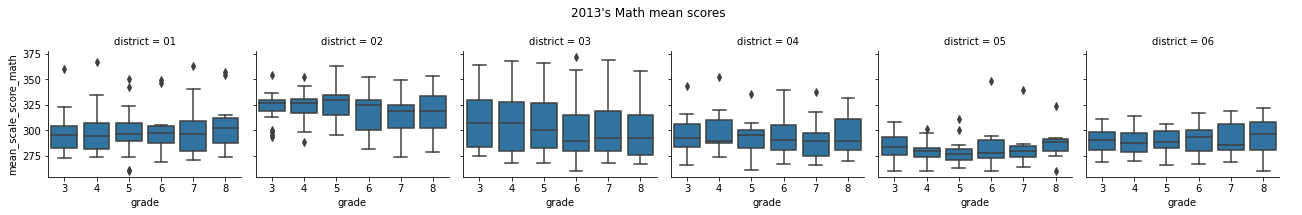

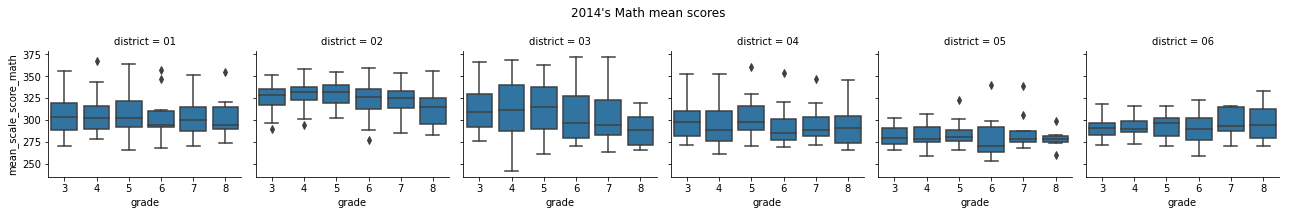

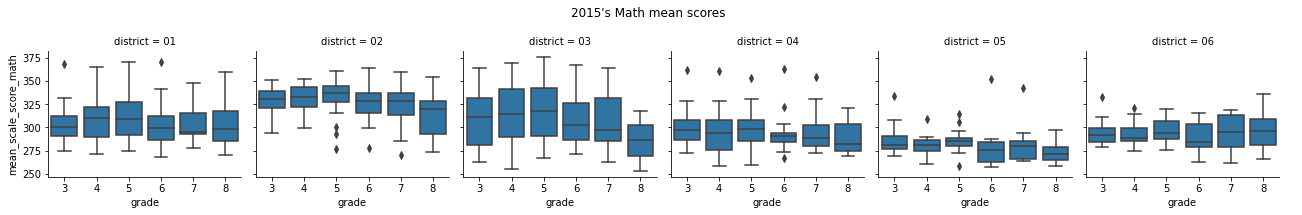

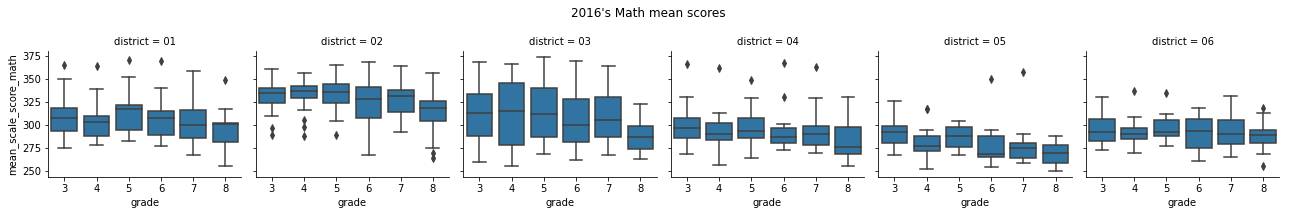

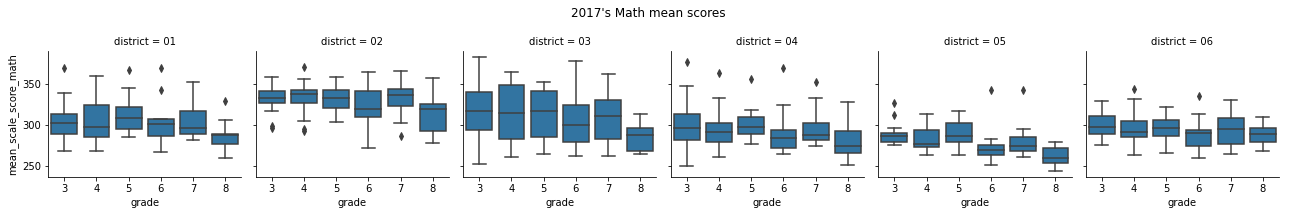

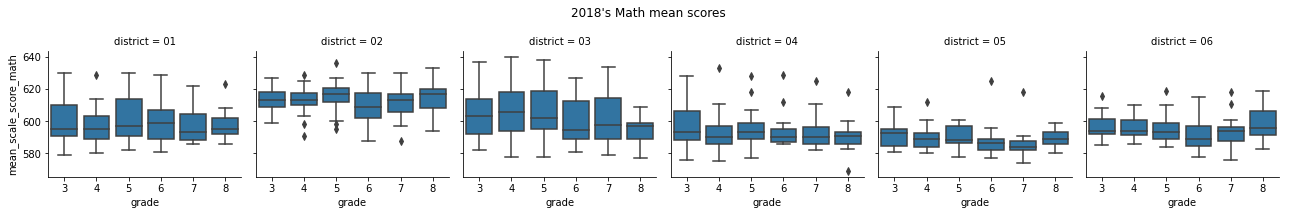

In [14]:

# * Create a series of tables where each table shows the mean math scoring disturbition across different districts of school year
for year in new_df.year.unique().tolist():
    dfB = new_df[new_df.year == year]
    sea = sns.FacetGrid(data=dfB, col = "district")
    sea.fig.suptitle(f"{year}'s Math mean scores")
    sea.map(sns.boxplot,"grade", "mean_scale_score_math")
    sea.add_legend()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.10/l

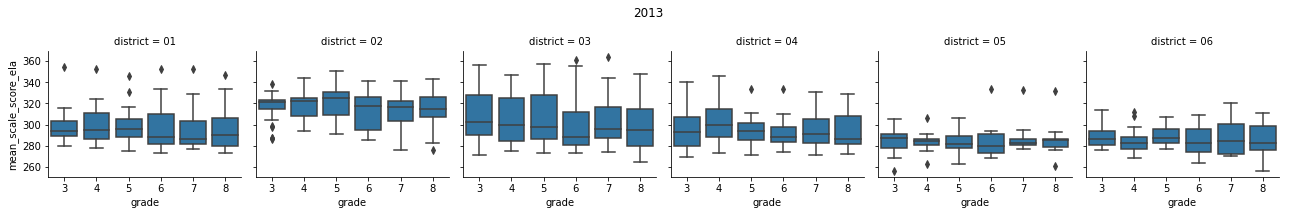

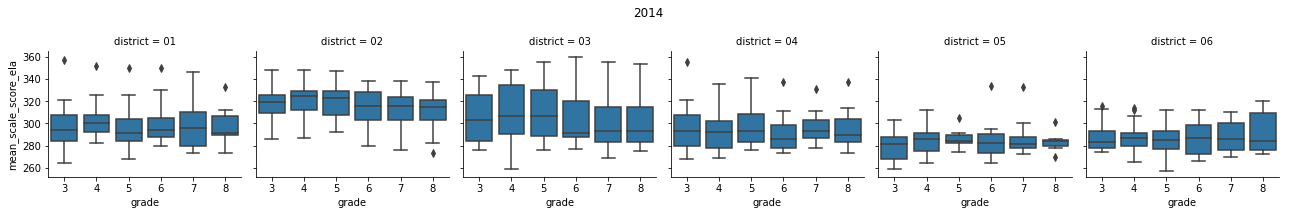

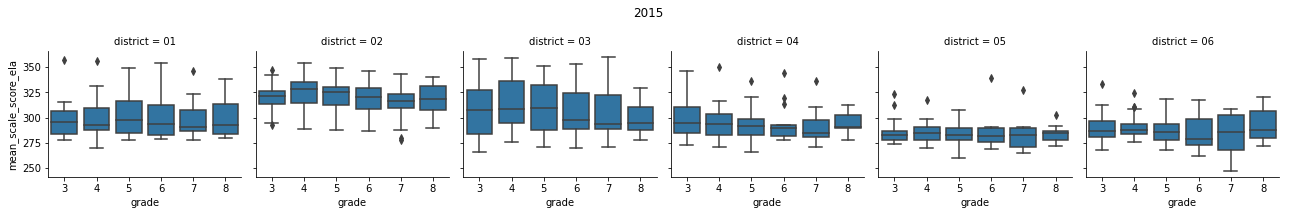

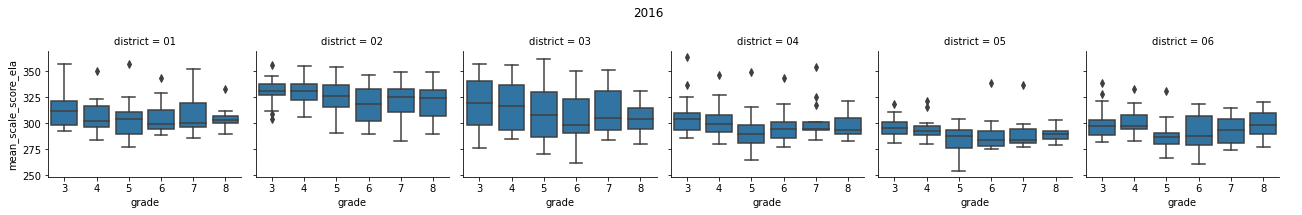

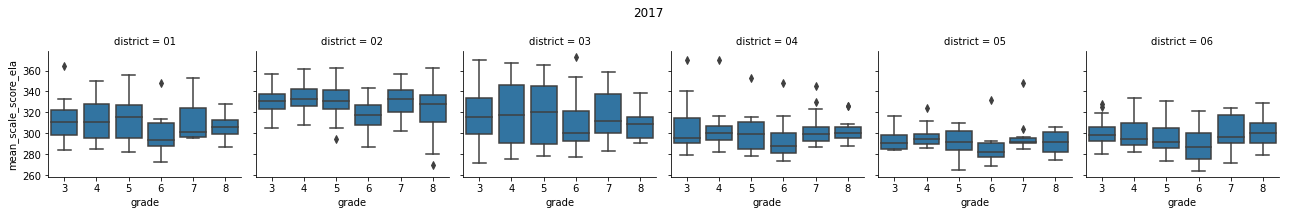

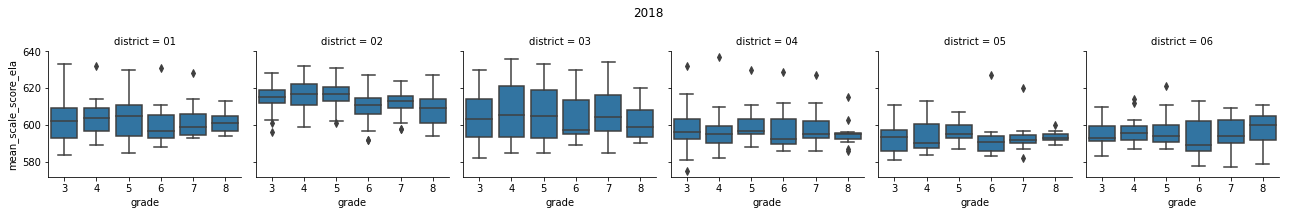

In [15]:

# * Create a series of tables where each table shows the mean ELA scoring disturbition across different districts of school year
for year in new_df.year.unique().tolist():
    dfB = new_df[new_df.year == year]
    sea = sns.FacetGrid(data=dfB, col = "district")
    sea.fig.suptitle(f"{year}")
    sea.map(sns.boxplot,"grade", "mean_scale_score_ela")
    sea.add_legend()

In [16]:

#? What are the average mean score for both math and ELA testing within Manhatten?
for year in new_df.year.unique().tolist():
    dfB = new_df[new_df.year == year]
    mean_m = dfB.mean_scale_score_math.mean()
    mean_e = dfB.mean_scale_score_ela.mean()
    print(f"{year}\nMATH mean  {mean_m} \nELA mean {mean_e}")

2013
MATH mean  301.3187702265372 
ELA mean 299.98381877022655
2014
MATH mean  304.45659163987136 
ELA mean 300.30707395498393
2015
MATH mean  305.36421725239614 
ELA mean 302.09424920127793
2016
MATH mean  305.3154574132492 
ELA mean 307.5173501577287
2017
MATH mean  305.8513931888545 
ELA mean 310.25696594427245
2018
MATH mean  600.6317411402157 
ELA mean 603.1571648690293


In [17]:

# ? Why are 2018 scores higher than pervious years?

# ? Was there less students who tested?
test_df = new_df.groupby(['year'])
for y in sorted(new_df.year.unique().tolist()):
    dfB = new_df[new_df.year == y]
    total_math = dfB.mean_scale_score_math.sum()
    total_ela = dfB.mean_scale_score_ela.sum()
    print(f'{y}\'s total student tested in math: {total_math}')
    print(f'{y}\'s total student tested in ELA: {total_ela}\n')

# * There were more than students that took the tests in 2018 than any other pervious year


2013's total student tested in math: 186215
2013's total student tested in ELA: 185390

2014's total student tested in math: 189372
2014's total student tested in ELA: 186791

2015's total student tested in math: 191158
2015's total student tested in ELA: 189111

2016's total student tested in math: 193570
2016's total student tested in ELA: 194966

2017's total student tested in math: 197580
2017's total student tested in ELA: 200426

2018's total student tested in math: 389810
2018's total student tested in ELA: 391449



2014's District 06 Info for Grade 5
Average Math Score: 295.3157894736842 
Average ELA Score: 295.3157894736842 
Percentage of school with higher than average math scores: 52.63%
Percentage of school with lower than average math scores: 47.37%
Percentage of school with higher than average ela scores: 21.05%
Percentage of school with lower than average ela scores: 78.95%


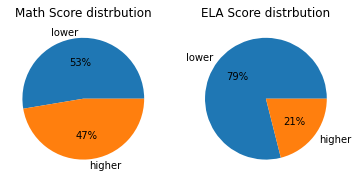

In [18]:
grouped_df = new_df.groupby(['district','year','grade'])

# * Display information of average score of a grade level of district within a time period in relation to the average score
def get_screenshot():

    d = input(f'District Numbers: {new_df.district.unique().tolist()},\tEnter district number of school... ')
    if(len(d)) == 1:
        d = "0"+d

    y = input(f'School Years: {new_df.year.unique().tolist()},\nEnter school year... ')


    g = input(f'Grade Levels: {new_df.grade.unique().tolist()},\nEnter grade level')
    unique_df = grouped_df.get_group((d,y,g))
    unique_df = unique_df[['school_number','school_name','number_tested_math','number_tested_ela','mean_scale_score_math','mean_scale_score_ela']]
    unique_df.reset_index(drop=True, inplace=True)

    print(f'{y}\'s District {d} Info for Grade {g}')
    
    # * Uncomment to print first five rows of dataframe
    # print(unique_df.head(5))

    # * Uncomment to print uncleaned statstics of the dataframe
    # print(unique_df.describe())

    # * Uncomment to print mean values of the dateframe
    # print(f'Average amount of test given out to each school: \nMath:{unique_df.number_tested_math.mean()} \nELA:{unique_df.number_tested_ela.mean()} ')
    # print(f'Average score of test in district {d}: \nMath:{unique_df.mean_scale_score_math.mean()} \nELA:{unique_df.mean_scale_score_ela.mean()} ')

    # * Uncomment to export dataframe as csv file
    # file_name = f'district{d}_year{y}_grade{g}_test_result_data'
    # unique_df.to_csv(f'{file_name}.csv')

    # * Uncomment to export dataframe as excel file
    # file_name = f'district{d}_year{y}_grade{g}_test_result_data'
    # unique_df.to_csv(f'{file_name}.xlsx')

    # * Calculate if scores are higher or lower than averages
    mean_math = unique_df.mean_scale_score_math.mean()
    mean_ela = unique_df.mean_scale_score_math.mean()
    compare_math_mean = lambda x: "higher" if x>mean_math else "lower"
    compare_ela_mean = lambda x: "higher" if x>mean_ela else "lower"
    unique_df["compared_to_mean_math"] = unique_df.mean_scale_score_math.apply(compare_math_mean)
    unique_df["compared_to_mean_ela"] = unique_df.mean_scale_score_ela.apply(compare_ela_mean)

    # * Calculate percentage of schools with higher or lower scores for both test 
    math_higher_percentage = round((len(unique_df[unique_df.compared_to_mean_math == 'higher'])/len(unique_df) * 100),2) 
    math_lower_percentage = round((len(unique_df[unique_df.compared_to_mean_math == 'lower'])/len(unique_df) * 100),2) 
    ela_higher_percentage = round((len(unique_df[unique_df.compared_to_mean_ela == 'higher'])/len(unique_df) * 100),2) 
    ela_lower_percentage = round((len(unique_df[unique_df.compared_to_mean_ela == 'lower'])/len(unique_df) * 100),2) 
    print(f'Average Math Score: {mean_math} ')
    print(f'Average ELA Score: {mean_ela} ')
    print(f"Percentage of school with higher than average math scores: {math_higher_percentage}%")
    print(f"Percentage of school with lower than average math scores: {math_lower_percentage}%")
    print(f"Percentage of school with higher than average ela scores: {ela_higher_percentage}%")
    print(f"Percentage of school with lower than average ela scores: {ela_lower_percentage}%")

    # * Create a visual for distrbution of schools higher or lower than average
    math_data = unique_df.compared_to_mean_math.value_counts().tolist()
    ela_data = unique_df.compared_to_mean_ela.value_counts().tolist()
    math_total_values = len(math_data)
    ela_total_values = len(ela_data)
    math_data = [point/math_total_values for point in math_data]
    ela_data = [point/ela_total_values for point in ela_data]
    math_label = unique_df.compared_to_mean_math.unique().tolist()
    ela_label = unique_df.compared_to_mean_ela.unique().tolist()

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    axs[0].pie(math_data,labels=math_label,autopct='%.0f%%')
    axs[0].set_title("Math Score distrbution")
    axs[1].pie(ela_data,labels=ela_label,autopct='%.0f%%')
    axs[1].set_title("ELA Score distrbution")
    plt.show()
    

get_screenshot()

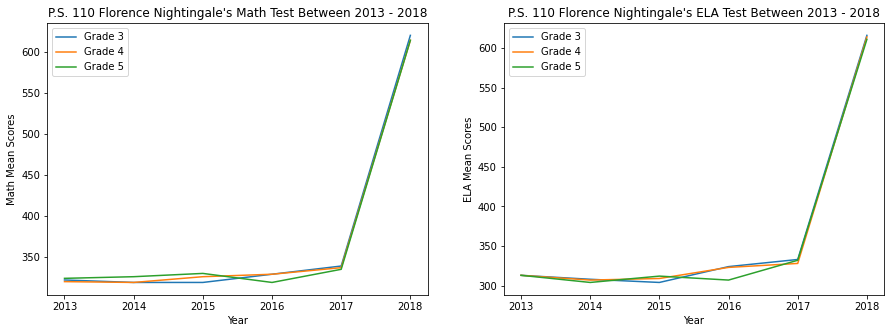

In [19]:

# * Graph the math score of school over the 6 year period

# * Inputs user needs (district number , school number)
d = input(f'District Numbers: {new_df.district.unique().tolist()},\tEnter district number of school... ')
if(len(d)) == 1:
        d = "0"+d

s = input(f'School Numbers: {new_df[new_df.district == d].school_number.unique()},\tEnter school number if school')

# * Constructs new dataframe to gather points for the graphs
main_df = new_df[(new_df.district == d) & (new_df.school_number == s)]
grades = main_df.grade.unique()
school_name = main_df.school_name.unique().tolist()[0]

# * Creates figure for graphs to be placed on
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for g in grades:
    # * Aggregates data for points in the graphs
    sub_df = main_df[main_df.grade == str(g)]
    years = sub_df.year.unique()
    t_years = years
    math_means = sub_df.mean_scale_score_math.tolist()
    ela_means = sub_df.mean_scale_score_ela.tolist()
    years, math_means = (list(t) for t in zip(*sorted(zip(years,math_means))))
    years, ela_means = (list(t) for t in zip(*sorted(zip(t_years,ela_means))))

    # * Inputs points of each grade into each table
    axs[0].plot(years,math_means,label=(f"Grade {g}"))
    axs[1].plot(years,ela_means,label=(f"Grade {g}"))

# * Places details of graph like axis name, legend name, and title of each graph in the figure
axs[0].set_ylabel("Math Mean Scores")
axs[0].set_xlabel('Year')
axs[0].set_title(f'{school_name}\'s Math Test Between 2013 - 2018')
axs[0].legend()
axs[1].set_ylabel("ELA Mean Scores")
axs[1].set_xlabel('Year')
axs[1].set_title(f'{school_name}\'s ELA Test Between 2013 - 2018')
axs[1].legend()

# * Displays figure
plt.show()




# Future Research Questions:
- Why are the 2018 scores higher for both the ELA and Math state test?
- Why are more schools having a mean score lower than the mean of their district?
